In [1]:
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import wandb

NumExpr defaulting to 8 threads.
NumExpr defaulting to 8 threads.


wandb.init(project="yolo-project", entity="pithecus")

# 데이터 로드

In [2]:
data_set = foz.load_zoo_dataset("voc-2012", split="train")
val_data_set = foz.load_zoo_dataset("voc-2012", split="validation")

GRID_SIZE = 16
IMG_SIZE = 256
Anchor_num = 6
Class_num = len(data_set.default_classes)
BBox_Properties_num = 5 # [top_left_x, top_left_y, w, h, confidence]

BATCH_SIZE = 4

classes = dict(zip(data_set.default_classes, range(len(data_set.default_classes)))) # 20가지 클래스들 라벨링 ex)비행기 : 0, 자전거 : 1, 배 : 2, ...

Split 'train' already downloaded
Loading 'voc-2012' split 'train'
 100% |███████████████| 5717/5717 [5.2s elapsed, 0s remaining, 1.1K samples/s]      
Dataset 'voc-2012-train' created
Split 'validation' already downloaded
Loading 'voc-2012' split 'validation'
 100% |███████████████| 5823/5823 [5.3s elapsed, 0s remaining, 1.2K samples/s]      
Dataset 'voc-2012-validation' created


In [6]:
print(len(data_set))
print(len(val_data_set))

5717
5823


## Generator

원래는 배치 크기만큼 직접 넣어주는 작업을 해서 학습시켰는데, 

이미지 개수가 배치 크기만큼 안떨어지면 모든 값이 0이고 정답도 없는 데이터를 넣어버렸다.

따라서 tensorflow의 from_generator를 통해 배치 크기만큼 만들도록 했는데,

직접 배치를 만들어서 넣어주는 것보다 60초가 단축됐다.

아래의 숨긴 셀들은 직접 만든 Generator

In [80]:
'''
data example

<Sample: {
    'id': '632ac61942050c00f708f951',
    'media_type': 'image',
    'filepath': '/home/diplab4/fiftyone/voc-2012/train/data/000001.jpg',
    'tags': BaseList(['train']),
    'metadata': None,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '632ac61942050c00f708f950',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'bottle',
                'bounding_box': BaseList([
                    0.3659999966621399,
                    0.0027777778450399637,
                    0.23400002717971802,
                    0.9972222447395325,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
        ]),
    }>,
}>
'''

"\ndata example\n\n<Sample: {\n    'id': '632ac61942050c00f708f951',\n    'media_type': 'image',\n    'filepath': '/home/diplab4/fiftyone/voc-2012/train/data/000001.jpg',\n    'tags': BaseList(['train']),\n    'metadata': None,\n    'ground_truth': <Detections: {\n        'detections': BaseList([\n            <Detection: {\n                'id': '632ac61942050c00f708f950',\n                'attributes': BaseDict({}),\n                'tags': BaseList([]),\n                'label': 'bottle',\n                'bounding_box': BaseList([\n                    0.3659999966621399,\n                    0.0027777778450399637,\n                    0.23400002717971802,\n                    0.9972222447395325,\n                ]),\n                'mask': None,\n                'confidence': None,\n                'index': None,\n            }>,\n        ]),\n    }>,\n}>\n"

In [3]:
def train_set_generator():
    train_dataset = data_set.iter_samples() # generator
    trainX = None
    trainY = None
    for data in train_dataset: # data : 하나의 이미지 내의 실제 물체에 대한 정보를 포함
        # 경로를 이용해 이미지를 불러온 후 넘파이 배열로 변환
        main_img = np.array(cv2.imread(data['filepath']))
        
        # 이미지의 w, h 정보를 이용해 패딩
        padding_size = abs(main_img.shape[0] - main_img.shape[1])        
        padded_img_size = min(main_img.shape[0], main_img.shape[1]) + padding_size # max(main_img.shape[0], main_img.shape[1])
        
        # [0,1] 범위를 가지는 패딩된 부분의 상대 좌표 # 이미지에서 더 작은 축에 양쪽으로 패딩되므로 1/2을 곱해준다        
        pad_coord = np.array([abs(main_img.shape[1] - padded_img_size), abs(main_img.shape[0] - padded_img_size)]) / 2 / padded_img_size
        
        # [0,255] to [0,1]
        trainX = tf.image.resize_with_pad(main_img, IMG_SIZE, IMG_SIZE) / 255.
        
        # Output format
        # [16, 16, 6, 25]
        y = np.zeros((
            GRID_SIZE, 
            GRID_SIZE, 
            Anchor_num, 
            Class_num + BBox_Properties_num
        ), dtype=np.float32)
        
        
        for label in data['ground_truth']['detections']:
            # [top_left_x, top_left_y, w, h, confidence] # BBox 표현에 있어서 [x1, y1, x2, y2]와 [center_x, center_y, w, h]도 있다            
            bounding_box = label['bounding_box']

            #바운딩 박스의 중심 점과 사이즈를 얻음
            bounding_box_center_point = np.array(bounding_box[:2]) * np.array([main_img.shape[1], main_img.shape[0]]) / padded_img_size + pad_coord
            bounding_box_size = np.array(bounding_box[2:]) * np.array([main_img.shape[1], main_img.shape[0]]) / padded_img_size
            
            # [top_left_x, top_left_y, w, h] to [center_x, center_y, w, h] 
            bounding_box_center_point += (bounding_box_size / 2)            
            
            object_class = classes[label['label']]            
            
            # center point가 그리드 내에서 어디에 위치하는지를 얻음 <-> 이미지 내의 0~1 좌표를 그리드 셀 내의 0~1 좌표로 변환
            # 이후 다시 전체 이미지에서의 좌표를 얻으려면, center point가 속한 그리드의 좌표를 더해야함
            # 이미지 내의 좌표의 처음과 끝을 픽셀의 개수가 아닌 0~1로 나태내고 있기 때문
            
            bounding_box_grid_coord = bounding_box_center_point * GRID_SIZE
            
            idx, idy = bounding_box_grid_coord.astype(np.int16) # center point가 속한 그리드의 좌표
            bounding_box_grid_coord = bounding_box_grid_coord - np.array([idx, idy])
            
            # 한 grid cell 안에 Anchor_num 이상의 gt를 가질 수 없도록
            position = -1
            for i in range(Anchor_num):
                if y[idy, idx, i, 0] == 0:
                    position = i
                    break

            if position != -1:
                y[idy, idx, position] = np.concatenate([
                    bounding_box_grid_coord, # 그리드 내의 좌표
                    bounding_box_size, # 바운딩 박스의 크기, 전체 이미지 사이즈에 비례
                    [1], # confidence
                    tf.one_hot(object_class, Class_num) # 클래스의 one hot 형태
                ])

        trainY = y
        
        yield (trainX, trainY)

In [4]:
def validation_set_generator():
    validation_dataset = val_data_set.iter_samples()
    validationX = None
    validationY = None
    for data in validation_dataset:
        main_img = np.array(cv2.imread(data['filepath']))
        
        padding_size = abs(main_img.shape[0] - main_img.shape[1])
        
        padded_img_size = min(main_img.shape[0], main_img.shape[1]) + padding_size
        
        pad_coord = np.array([abs(main_img.shape[1] - padded_img_size), abs(main_img.shape[0] - padded_img_size)]) / 2 / padded_img_size
        
        validationX = tf.image.resize_with_pad(main_img, IMG_SIZE, IMG_SIZE) / 255.
        
        # [16, 16, 6, 25]
        y = np.zeros((
            GRID_SIZE, 
            GRID_SIZE, 
            Anchor_num, 
            Class_num + BBox_Properties_num
        ), dtype=np.float32)

        for label in data['ground_truth']['detections']:

            bounding_box = label['bounding_box']

            #바운딩 박스의 중심 점과 사이즈를 얻음
            bounding_box_center_point = np.array(bounding_box[:2]) * np.array([main_img.shape[1], main_img.shape[0]]) / padded_img_size + pad_coord
            bounding_box_size = np.array(bounding_box[2:]) * np.array([main_img.shape[1], main_img.shape[0]]) / padded_img_size
            bounding_box_center_point += ((bounding_box_size) / 2)

            object_class = classes[label['label']]

            # center point가 그리드 내에서 어디에 위치하는지를 얻음
            # 이후 다시 전체 이미지에서의 좌표를 얻으려면, center point가 속한 그리드의 좌표를 더해야함
            bounding_box_grid_coord = bounding_box_center_point * GRID_SIZE
            idx, idy = bounding_box_grid_coord.astype(np.int16) # center point가 속한 그리드의 좌표
            bounding_box_grid_coord = bounding_box_grid_coord - np.array([idx, idy])

            # 해당 그리드에 찍을 점을 넣음 Anchor_num을 넘을 수 없음
            position = -1
            for i in range(Anchor_num):
                if y[idy, idx, i, 0] == 0:
                    position = i
                    break

            if position != -1:
                y[idy, idx, position] = np.concatenate([
                    bounding_box_grid_coord, # 그리드 내의 좌표
                    bounding_box_size, # 바운딩 박스의 크기, 전체 이미지 사이즈에 비례
                    [1], # confidence
                    tf.one_hot(object_class, Class_num) # 클래스의 one hot 형태
                ])

        validationY = y
        
        yield (validationX, validationY)

# Loss
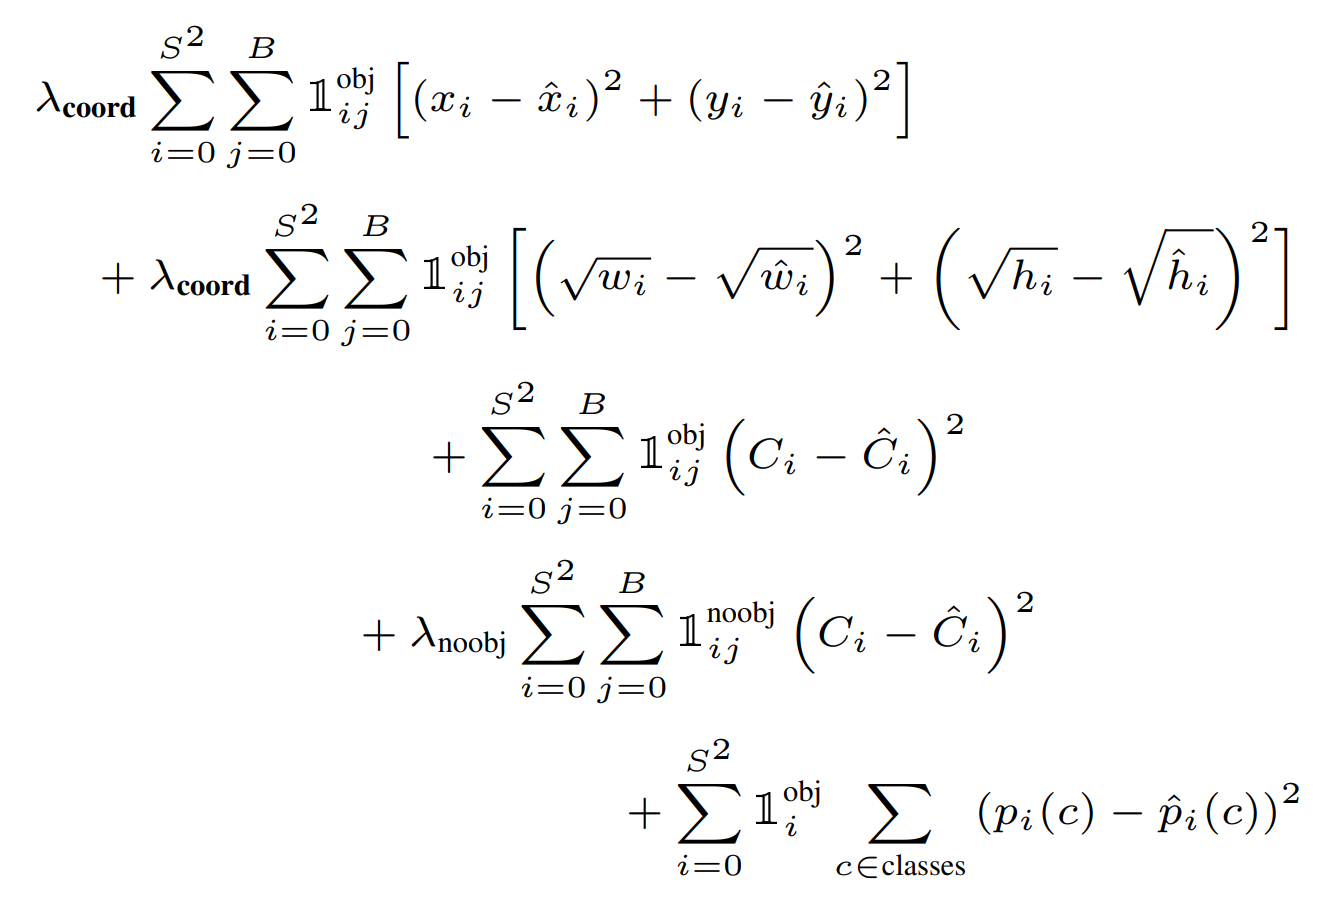

---

```
Output
(-1, GRID_SIZE, GRID_SIZE, dot_count, (x, y, w, h, confidence, [c_1, ... ,c_20]))
(-1, 16, 16, 6, 25)
```

## YOLO Loss Function

`tf.argmax` : https://webnautes.tistory.com/1234

In [7]:
# 진행중
class YOLOLoss(tf.keras.losses.Loss):
    # 가중치
    lambda_conf_obj = 1
    lambda_conf_noobj = 0.5
    lambda_coord_obj = 5
    lambda_coord_noobj = 1
    
    #bce = wbce#tf.keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.NONE)
    #mse = tf.keras.losses.MeanSquaredError(reduction = 'sum')
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)    
    
    ## wbce를 쓰고 싶은 경우를 위한 건가?
    def wbce(self, y_true, y_pred, w=1):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        bce = -w*y_true*tf.math.log(tf.maximum(1e-5, y_pred))-(1-y_true)*tf.math.log(tf.maximum(1e-5, 1-y_pred))
        
        return bce
    
    def IoU(self, y_true, y_pred):
        y_true_ext = tf.expand_dims(y_true, -2) # (-1, 16, 16, 6, 1, 25)
        y_pred_ext = tf.expand_dims(y_pred, -3) # (-1, 16, 16, 1, 6, 25)
        
        idx_x = tf.reshape(tf.range(GRID_SIZE, dtype=tf.float32), (1, GRID_SIZE, 1, 1, 1)) # (1, 16, 1, 1, 1)
        idx_y = tf.reshape(tf.range(GRID_SIZE, dtype=tf.float32), (1, 1, GRID_SIZE, 1, 1)) # (1, 1, 16, 1, 1)
        
        # obj[...,idx] <== (-1, 16, 16, 6, idx)에 존재하는 값을 반환 
        y_true_left = (idx_x + y_true_ext[...,0])/GRID_SIZE - y_true_ext[...,2]/2
        y_true_right = (idx_x + y_true_ext[...,0])/GRID_SIZE + y_true_ext[...,2]/2
        y_true_bottom = (idx_y + y_true_ext[...,1])/GRID_SIZE - y_true_ext[...,3]/2 # 왼쪽 위가 (0,0)
        y_true_top = (idx_y + y_true_ext[...,1])/GRID_SIZE + y_true_ext[...,3]/2
        
        y_pred_left = (idx_x + y_pred_ext[...,0])/GRID_SIZE - y_pred_ext[...,2]/2
        y_pred_right = (idx_x + y_pred_ext[...,0])/GRID_SIZE + y_pred_ext[...,2]/2
        y_pred_bottom = (idx_y + y_pred_ext[...,1])/GRID_SIZE - y_pred_ext[...,3]/2
        y_pred_top = (idx_y + y_pred_ext[...,1])/GRID_SIZE + y_pred_ext[...,3]/2
        
        y_intersection_box_left = tf.maximum(y_true_left, y_pred_left)
        y_intersection_box_right = tf.minimum(y_true_right, y_pred_right)
        y_intersection_box_bottom = tf.maximum(y_true_bottom, y_pred_bottom)
        y_intersection_box_top = tf.minimum(y_true_top, y_pred_top)
        
        # intersection이 없을 수도 있기 때문에 relu처리를 해준다.
        iou_intersection = tf.nn.relu(y_intersection_box_right - y_intersection_box_left) * tf.nn.relu(y_intersection_box_top - y_intersection_box_bottom)
        
        iou_union = tf.abs(y_true_right - y_true_left)*tf.abs(y_true_top - y_true_bottom) + tf.abs(y_pred_right - y_pred_left)*tf.abs(y_pred_top - y_pred_bottom) - iou_intersection
        iou_union = tf.where(iou_union==0, 1e-17, iou_union) # iou_union이 0인 것들을 찾아 1e-17로 만든다.
        iou = iou_intersection / iou_union
        
        # (-1, 16, 16, 6, 6)
        return iou
        
    def call(self, y_true, y_pred, sample_weight=None):
        # (-1, 16, 16, 6, 25)
        #y_true = tf.reshape(y_true, tf.concat([y_true.shape[:-1], [6, -1]], axis=-1))
        #y_pred = tf.reshape(y_pred, tf.concat([y_pred.shape[:-1], [6, -1]], axis=-1))
        
        confidence_ground_truth = y_true[...,4] # (-1, 16, 16, 6, 25) # 25 : (x, y, w, h, confidence)
        
        iou = self.IoU(y_true, y_pred) # (-1, 16, 16, 6, 6)
        
        resp_idx = tf.argmax(iou, axis=-1) # (-1, 16, 16, 6) 각 그리드당 iou(true --> pred)가 최대인 인덱스가 저장되어있음
        
        # (-1, 16, 16, 6, 1, 1, 25)
        y_true_resp = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, 1, Anchor_num, 1, Class_num + BBox_Properties_num))
        
        # (-1, 16, 16, 1, 6, 1, 25)
        y_pred_resp = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, Anchor_num, 1, 1, Class_num + BBox_Properties_num))
        
        # (-1, 16, 16, 6, 1, 2, 25) 6번째 차원의 1번째 값이 비어있음    
        y_true_resp = tf.concat([y_true_resp, tf.zeros_like(y_true_resp)], axis=-2)
        
        # (-1, 16, 16, 1, 6, 2, 25) 6번째 차원의 1번째 값이 비어있음    
        y_pred_resp = tf.concat([tf.zeros_like(y_pred_resp), y_pred_resp], axis=-2)
        
        # (-1, 16, 16, 6, 6, 2, 25)
        y_resp = y_true_resp + y_pred_resp
        
        # (-1, 16, 16, 25) 
        y_resp = tf.gather_nd(y_resp, resp_idx)
        
        y_pred_resp_mask = tf.expand_dims(
            tf.cast(
                tf.reduce_sum(
                    tf.one_hot(resp_idx, Anchor_num) * tf.expand_dims(confidence_ground_truth, -1), -2
                ) > 0, 
                tf.float32
            )
            , -1
        )
        y_pred_no_resp_mask = 1 - y_pred_resp_mask
        y_pred_resp = y_pred * y_pred_resp_mask
        y_pred_no_resp = y_pred * y_pred_no_resp_mask
        
        y_true_resp_mask = tf.expand_dims(
            tf.cast(
                tf.reduce_sum(
                    tf.one_hot(resp_idx, Anchor_num) * tf.expand_dims(confidence_ground_truth, -1), -1
                ) > 0, 
                tf.float32
            ), -1
        )
        y_true_no_resp_mask = 1 - y_true_resp_mask
        y_true_resp = y_true * y_true_resp_mask
        y_true_no_resp = y_true*y_true_no_resp_mask
        
        y_pred_resp_size = y_pred[...,2:4] * y_pred_resp_mask
        y_true_resp_size = y_true[...,2:4] * y_true_resp_mask
        
        coord_obj_loss = (y_true_resp[...,0:2] - y_pred_resp[...,0:2])
        coord_obj_loss = self.lambda_coord_obj * tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(coord_obj_loss**2, -1), -1), -1), -1)
        
        size_obj_loss = (y_true_resp_size[...,0:2] - y_pred_resp_size[...,0:2])
        size_obj_loss = self.lambda_coord_obj * tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(size_obj_loss**2, -1), -1), -1), -1)
        
        conf_obj_loss = self.bce(y_true_resp[...,4:5], y_pred_resp[...,4:5])
        conf_obj_loss = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(conf_obj_loss, -1), -1), -1)
        
        conf_noobj_loss = self.bce(y_true_no_resp[...,4:5], y_pred_no_resp[...,4:5])
        conf_noobj_loss = self.lambda_conf_noobj * tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(conf_noobj_loss, -1), -1), -1)
        
        cls_loss = tf.keras.losses.binary_focal_crossentropy(y_true_resp[...,5:], y_pred_resp[...,5:])
        cls_loss = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(cls_loss, -1), -1), -1)
        
        return tf.minimum(tf.reduce_mean(coord_obj_loss + size_obj_loss + conf_obj_loss + conf_noobj_loss + cls_loss), y_true.dtype.max)

## YOLO Activation

In [8]:
# 여러 terms에 대해 따로 activation이 필요함

class YoloAct(tf.keras.layers.Activation):
    def __init__(self, activation, **kwargs):
        super(YoloAct, self).__init__(activation, **kwargs)
        self.__name__ = 'YOLO Activation'

# k-means clustring을 통해 얻은 anchor box의 크기들 (x, y)
anchor_boxes = np.array([[0.22234208, 0.41457496],
                         [0.04784555, 0.05526209],
                         [0.47706306, 0.69346809],
                         [0.16044952, 0.17249361],
                         [0.48425412, 0.26785555],
                         [0.88359258, 0.50848813]])        
        
def yoloAct(output):
    tout = tf.reshape(output, (-1, GRID_SIZE, GRID_SIZE, Anchor_num, Class_num + BBox_Properties_num))
    a = tf.nn.sigmoid(tout[...,0:2])
    b = tf.math.exp(tout[...,2:4]) * anchor_boxes # exp함수와 함께 학습시킬 경우, 엄청나게 학습을 잘하게 된다.
    c = tf.nn.sigmoid(tout[...,4:])
    
    return tf.concat([a, b, c], axis=-1)

tf.keras.utils.get_custom_objects().update({'yolo': YoloAct(yoloAct)})

## YOLO mAP

In [9]:
class mAP(tf.keras.metrics.Metric):
    def __init__(self, class_number = Class_num, iou_thresholds=0.5, name='AP*', **kwargs):
        self.iou_thresholds = iou_thresholds
        self.class_number = class_number
        
        if name == 'AP*': name = name[:-1]+str(int(iou_thresholds*100))
        
        super().__init__(name=name, **kwargs)
        
        # 클래스별 AP를 계산하기 위해 클래스의 이름을 가진 weight를 클래스 개수만큼 리스트로 만든다.
        self.APs = [self.add_weight(name='AP_'+str(i), initializer='zeros') for i in range(class_number)]
        
        # 클래스별 AP를 계산하기 위해 각 클래스별 AP가 저장될 weight를 클래스 개수만큼 리스트로 만든다.
        self.value_num = [self.add_weight(name='value_num_'+str(i), initializer='zeros') for i in range(class_number)]
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, Anchor_num, BBox_Properties_num + Class_num))
        y_pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, Anchor_num, BBox_Properties_num + Class_num))
        
        idx_y = tf.reshape(tf.range(GRID_SIZE, dtype=tf.float32), (1, GRID_SIZE, 1, 1, 1))
        idx_x = tf.reshape(tf.range(GRID_SIZE, dtype=tf.float32), (1, 1, GRID_SIZE, 1, 1))
        
        # 어떤 그리드에 해당하는 점인지를 명시
        y_true = tf.concat(
            [
                (y_true[...,0:1] + idx_x) / GRID_SIZE,
                (y_true[...,1:2] + idx_y) / GRID_SIZE,
                y_true[...,2:]
            ], 
            axis=-1
        )
        y_pred = tf.concat(
            [
                (y_pred[...,0:1] + idx_x) / GRID_SIZE,
                (y_pred[...,1:2] + idx_y) / GRID_SIZE,
                y_pred[...,2:]
            ], 
            axis=-1
        )
        
        # 기존에 3차원으로 이루어졌던, 그리드의 세로, 가로, 그리드당 점 개수를 모두 곱해서 한 줄로 만들어준다.
        # shape: (-1, 16x16x6, 25)
        y_true = tf.reshape(y_true, (-1, GRID_SIZE * GRID_SIZE * Anchor_num, BBox_Properties_num + Class_num))
        y_pred = tf.reshape(y_pred, (-1, GRID_SIZE * GRID_SIZE * Anchor_num, BBox_Properties_num + Class_num))
        
        for i in range(tf.shape(y_true)[0]): # batch 에 대해
            # shape: (1, 16x16x6, 25)
            y_true_per_batch = y_true[i:i+1]
            y_pred_per_batch = y_pred[i:i+1]
            
            # shape: (1, 16x16x6)
            # 모든 값이 0일 경우, argmax는 맨 첫번째 인덱스를 내놓는다.
            # 정답 데이터가 모두 0인 경우를 처리하기 위해, 마지막 차원에 대한 sum을 진행한 후, -1을 한 값을 더해주면
            # argmax가 0으로 내놓은 값을 모두 -1로 만들어, 이후 처리에서 오류가 없도록 할 수 있다.
            y_true_class_idx = tf.argmax(y_true_per_batch[...,5:], axis=-1) + tf.cast((tf.reduce_sum(y_true_per_batch[...,5:], -1) - 1), tf.int64)
            y_pred_class_idx = tf.argmax(y_pred_per_batch[...,5:], axis=-1)
            
            for target_class_idx in range(self.class_number): # 클래스 개수에 대해
                # shape: (-1, 25)
                y_true_target_point = y_true_per_batch[y_true_class_idx == target_class_idx]
                y_pred_target_point = y_pred_per_batch[y_pred_class_idx == target_class_idx]
                
                if tf.shape(y_true_target_point)[0] > 0: # y_true_class 가 target_class_idx 와 같은 경우 첫번째 차원의 크기가 0보다 큼
                    if tf.shape(y_pred_target_point)[0] > 0:
                        # 클래스를 잘 예측한 경우
                        #print(list(classes.keys())[target_class_idx])
                        AP, num = self.AP(y_true_target_point, y_pred_target_point)
                        #print("---")
                        
                        self.APs[target_class_idx].assign_add(AP*num) # 평균의 평균을 내지 않기 위해, 클래스를 잘 예측한 개수랑 곱해준다.
                        self.value_num[target_class_idx].assign_add(num)
                    else:
                        # 클래스 예측을 실패한경우
                        self.APs[target_class_idx].assign_add(0.)
                        self.value_num[target_class_idx].assign_add(tf.cast(tf.shape(y_true_target_point)[0], tf.float32))
        
    def AP(self, y_true_target_point, y_pred_target_point):
        # each parameter has (-1, 25) shape

        confidence_ground_truth = y_true_target_point[...,4]

        # 이후 matrix를 구성하기 위한 전처리 과정
        y_true_point_direction_row = tf.expand_dims(y_true_target_point, 1) # shape: (-1, 1, 25)
        y_pred_point_direction_column = tf.expand_dims(y_pred_target_point, 0) # shape: (1, -1, 25)

        # shape: (1, -1, 25)
        y_pred_point_sorted_by_confidence = tf.gather(
            y_pred_point_direction_column, 
            tf.argsort(y_pred_point_direction_column[...,4], direction="DESCENDING")[0],
            axis=1
        )

        # shape: (-1, 1)
        y_true_box_left = y_true_point_direction_row[...,0] - y_true_point_direction_row[...,2] / 2
        y_true_box_right = y_true_point_direction_row[...,0] + y_true_point_direction_row[...,2] / 2
        y_true_box_bottom = y_true_point_direction_row[...,1] - y_true_point_direction_row[...,3] / 2
        y_true_box_top = y_true_point_direction_row[...,1] + y_true_point_direction_row[...,3] / 2

        # shape: (1, -1)
        y_pred_box_left = y_pred_point_sorted_by_confidence[...,0] - y_pred_point_sorted_by_confidence[...,2] / 2
        y_pred_box_right = y_pred_point_sorted_by_confidence[...,0] + y_pred_point_sorted_by_confidence[...,2] / 2
        y_pred_box_bottom = y_pred_point_sorted_by_confidence[...,1] - y_pred_point_sorted_by_confidence[...,3] / 2
        y_pred_box_top = y_pred_point_sorted_by_confidence[...,1] + y_pred_point_sorted_by_confidence[...,3] / 2

        # shape: (y_true box count, y_pred box count)
        y_iou_left = tf.maximum(y_true_box_left, y_pred_box_left)
        y_iou_right = tf.minimum(y_true_box_right, y_pred_box_right)
        y_iou_bottom = tf.maximum(y_true_box_bottom, y_pred_box_bottom)
        y_iou_top = tf.minimum(y_true_box_top, y_pred_box_top)

        iou_intersection = tf.nn.relu(y_iou_right - y_iou_left) * tf.nn.relu(y_iou_top - y_iou_bottom)

        # shape: (y_true box count, y_pred box count)
        iou_union = tf.abs(y_true_box_right - y_true_box_left)*tf.abs(y_true_box_top - y_true_box_bottom) + tf.abs(y_pred_box_right - y_pred_box_left)*tf.abs(y_pred_box_top - y_pred_box_bottom) - iou_intersection

        iou = iou_intersection / iou_union # (y_true box count, y_pred box count)
        
        iou_transposed = tf.transpose(iou) # (y_pred box count, y_true box count)
        
        y_true_box_count = tf.cast(tf.shape(iou)[0], tf.int32)
        y_pred_box_count = tf.cast(tf.shape(iou_transposed)[0], tf.int32)

        # shape: (y_pred box count, y_true box count)
        max_iou_mask = tf.one_hot(tf.argmax(iou_transposed, -1), y_true_box_count)

        # shape: (y_pred box count, y_true box count)
        # threshold를 넘지 못하는 iou를 나타내는 one_hot을 모두 0을 가지는 텐서로 만든다. ex) [0, 0, 0, 1] --> [0, 0, 0, 0]
        over_thershold_iou_mask = max_iou_mask * tf.expand_dims(tf.cast(tf.reduce_max(iou_transposed, -1) > self.iou_thresholds, tf.float32), -1)
        
        # threshold를 넘지 못하는 iou들을 모았을 때, 어떤 객체는 모델이 iou를 하나도 못넘긴 경우가 있다.
        # 이때 argmax를 쓰면 항상 맨 처음 인덱스가 뽑혀 나오게 되는데, 이는 잘못된 mAP 계산을 야기하므로
        # 모든 값이 0일 경우와 1이상인 경우를 일렬로 만들어 TPs_ipu를 만들때 곱해준다.
        '''
        [[0, 0, 0]
         [0, 1, 0]
         [1, 0, 0]] 의 경우 zero_check를 통해 곱해주지 않으면
         
        [[0, 0, 1]
         [0, 1, 0]
         [1, 0, 0]] 이렇게 argmax가 뽑혀 나오게 되고, 이는 옳지 않은 결과이다.
         
        따라서 우선 맨 처음의 텐서를 transpose 시킨다.
        
        [[0, 0, 1]
         [0, 1, 0]
         [0, 0, 0]]
         
        이제 맨 마지막 차원에 대해 sum을 구해준다.
        
        [[1]
         [1]
         [0]]
         
        이를 TPs_iou를 만들때 곱해주면, 한 객체에 대해 정답으로 예측한 것이 없는 경우를 처리할 수 있게된다.
        '''
        zero_checker = tf.expand_dims(tf.reduce_sum(tf.transpose(over_thershold_iou_mask), -1), axis=-1)
        zero_checker = tf.where(zero_checker>1, 1.0, zero_checker)
        
        # shape: (y_pred box count, y_true box count)
        TPs_iou = tf.transpose(tf.one_hot(tf.argmax(over_thershold_iou_mask, axis=-2), y_pred_box_count, axis=1) * zero_checker)
        
        # shape: (y_pred box count, )
        TPs_vector = tf.reduce_sum(TPs_iou, axis=-1)

        # shape: (y_pred box count, )
        TPs = tf.math.cumsum(TPs_vector)

        TP_FP_sum = tf.math.cumsum(tf.ones_like(TPs))
        TP_FN_sum = tf.reduce_sum(confidence_ground_truth)

        # shape: (y_pred box count, )
        Precisions = TPs / TP_FP_sum
        Recalls = TPs / TP_FN_sum
        

        '''
        0 ~ 1.0 까지 0.1 단위로 존재하는 11개의 값이 있다.
        이때 Recalls의 값들을 0부터 차례대로, 
        0보다 같거나 큰 Recalls의 값들, 0.1보다 같거나 큰 Recalls의 값들... 1.0 보다 같거나 큰 recalls의 값들로 구성된 2차원 텐서를 구성한다.
        이 2차원 텐서를 Recalls_eleven_points라고 하고, 먼저 boolean형으로 만들어준 다음, 다시 float32로 만들어준다.
        Recalls_eleven_points[1] : 0.1 보다 같거나 큰 Recall 값들이 1.0, 작은 값들이 0.0으로 되어있는 1차원 텐서

        AP를 계산할 때, 11개로 끊긴 recall의 값들중 0부터 차례대로
        0보다 큰 recall값에 대응하는 precision중 가장 최댓값이 해당 recall이 0일때의 precision값이 된다.
        11개로 끊겨있으므로 총 11개의 precision값이 나오게 된다. --> Precisions_eleven_points
        Precisions_eleven_points[4] : 0.4보다 큰 recall값에 대응하는 precision중 최댓값
        '''
        
        Recalls_eleven_points = tf.cast(
            tf.expand_dims(Recalls, 0) >= tf.expand_dims(tf.cast(tf.range(0, 1.1, 0.1, dtype=tf.float64), tf.float32), -1)
            , tf.float32
        )

        Precisions_eleven_points = tf.reduce_max(Precisions * Recalls_eleven_points, axis=-1)
        
        return tf.reduce_mean(Precisions_eleven_points), tf.cast(tf.shape(y_true_target_point)[0], tf.float32) # AP, y_true target point count
    

    def result(self):
        mAP = 0
        c = 0.

        for i in range(self.class_number):
            ap = 0.
            if self.value_num[i] > 0:
                ap = (self.APs[i] / self.value_num[i])
                c += 1.

            mAP += ap

        return mAP / tf.maximum(c, 1e-17)

    def reset_state(self):
        for i in range(self.class_number):
            self.APs[i].assign(0)
            self.value_num[i].assign(0)

## 메서드 테스트

In [102]:
tf.reshape(tf.range(GRID_SIZE, dtype=tf.float32), (1, 1, GRID_SIZE, 1, 1))

<tf.Tensor: shape=(1, 1, 16, 1, 1), dtype=float32, numpy=
array([[[[[ 0.]],

         [[ 1.]],

         [[ 2.]],

         [[ 3.]],

         [[ 4.]],

         [[ 5.]],

         [[ 6.]],

         [[ 7.]],

         [[ 8.]],

         [[ 9.]],

         [[10.]],

         [[11.]],

         [[12.]],

         [[13.]],

         [[14.]],

         [[15.]]]]], dtype=float32)>

In [103]:
test = tf.reshape(tf.range(12), (1,1,1,1,-1))
test = tf.reshape(test, tf.concat([test.shape[:-1], [6, -1]], axis=-1))
test

<tf.Tensor: shape=(1, 1, 1, 1, 6, 2), dtype=int32, numpy=
array([[[[[[ 0,  1],
           [ 2,  3],
           [ 4,  5],
           [ 6,  7],
           [ 8,  9],
           [10, 11]]]]]])>

In [104]:
test = tf.constant([[[0, 1, 2], [4, 3, 0],[1, 5, 0]]])
print(test.shape)
print(tf.argmax(test, 2))
print(tf.reduce_max(test, 2))
tf.reduce_max(test, axis=-1)

print(tf.zeros_like(test))
test = tf.concat([test, tf.zeros_like(test)], axis=0)
print(test)

(1, 3, 3)
tf.Tensor([[2 0 1]], shape=(1, 3), dtype=int64)
tf.Tensor([[2 4 5]], shape=(1, 3), dtype=int32)
tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(1, 3, 3), dtype=int32)
tf.Tensor(
[[[0 1 2]
  [4 3 0]
  [1 5 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(2, 3, 3), dtype=int32)


In [ ]:
test = YOLOLoss()
trainY = tf.reshape(trainY, (trainY.shape[0],16,16,-1))
print(trainY.shape)
print(test(tf.reshape(trainY, (trainY.shape[0],16,16,-1)), tf.random.uniform(trainY.shape)))

In [ ]:
a = tf.zeros((1, 16, 16, 6, 1, 1, 25))
b = tf.zeros((1, 16, 16, 1, 6, 1, 25))
i = tf.zeros((1, 16, 16, 6))

a = tf.concat([a, tf.zeros_like(a)], axis=-2)
b = tf.concat([tf.zeros_like(b), b], axis=-2)

c = a + b

print(c.shape)

print(tf.gather_nd(c, i))

# 모델

<div style="display: flex; justify-content: center;">
    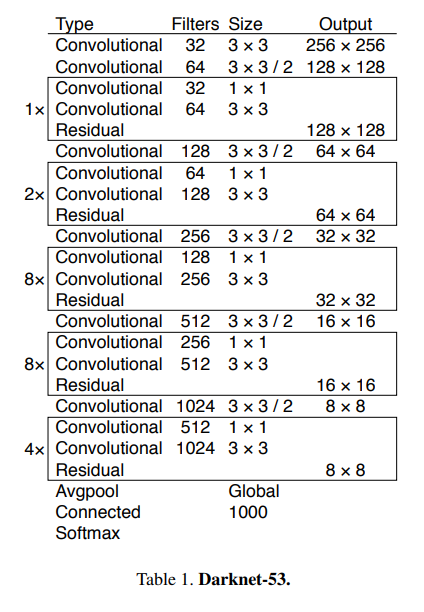
<div/>

## Darknet-53

- weighted bce

weighted bce를 class loss를 계산하는 부분에 적용했다.

아무래도 20개중에 1개만 정답이니까 틀렸을때의 로스를 키워주면 학습을 더 잘 할 수 있다고 판단했다.

확실히 클래스 예측은 잘 하게 되었지만, 박스 크기를 잘 못잡음.

결국 weighted bce를 안 쓰게 됐음.


- Batchnormalization

마지막 레이어 바로 뒤에 놓으면 로스가 너무 커진다!!

결론적으로 bn을 적용하는것이 확실히 학습이 빨라짐.

### 결론

wbce와 bn을 가지고 돌리면 평균 50에폭에서 로스가 3초반으로 수렴하게 된다.

1. Residual 제대로 된 것 맞는지 (더해주는 값이 이상함, 블럭 끝나고 relu 없음)
2. 각 layer마다 relu 해주는게 맞는지
3. activation "yolo"가 Activation Class or def ?
4. 마지막에 global avgpooling, dense, softmax 없는 이유

In [11]:
def darknet_1(x):
    x1 = tf.keras.layers.Conv2D(32, 1, 1, padding="same", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu")(x1)
    x3 = tf.keras.layers.Add()([x, x2])
    # x3 = tf.keras.layers.ReLU()(x3) # 마지막 한번이 아니라 각 Conv2D마다 relu해주는게 맞나? # 성능으로 비교해보자
    
    return x3

def darknet_2(x):
    x1 = tf.keras.layers.Conv2D(64, 1, 1, padding="same", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(128, 3, 1, padding="same", activation="relu")(x1)
    x3 = tf.keras.layers.Add()([x, x2])
    
    return x3

def darknet_3(x):
    x1 = tf.keras.layers.Conv2D(128, 1, 1, padding="same", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(256, 3, 1, padding="same", activation="relu")(x1)
    x3 = tf.keras.layers.Add()([x, x2])
    
    return x3

def darknet_4(x):
    x1 = tf.keras.layers.Conv2D(256, 1, 1, padding="same", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(512, 3, 1, padding="same", activation="relu")(x1)
    x3 = tf.keras.layers.Add()([x, x2])
    
    return x3

def darknet_5(x):
    x1 = tf.keras.layers.Conv2D(512, 1, 1, padding="same", activation="relu")(x)
    x2 = tf.keras.layers.Conv2D(1024, 3, 1, padding="same", activation="relu")(x1)
    x3 = tf.keras.layers.Add()([x, x2])
    
    return x3

In [12]:
# New

inp = tf.keras.layers.Input((256,256,3))
h = tf.keras.layers.Conv2D(32, 3, 1, padding="same", activation="relu")(inp)
h = tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu")(h)
h = tf.keras.layers.MaxPool2D()(h)

h = tf.keras.layers.BatchNormalization()(h)
# 1
h = darknet_1(h)

h = tf.keras.layers.Conv2D(128, 3, 1, padding="same", activation="relu")(h)
h = tf.keras.layers.MaxPool2D()(h)

h = tf.keras.layers.BatchNormalization()(h)
# 2 x2
h = darknet_2(h)
h = darknet_2(h)

h = tf.keras.layers.Conv2D(256, 3, 1, padding="same", activation="relu")(h)
h = tf.keras.layers.MaxPool2D()(h)

h = tf.keras.layers.BatchNormalization()(h)
# 3 x8
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)
h = darknet_3(h)

h = tf.keras.layers.Conv2D(512, 3, 1, padding="same", activation="relu")(h)
h = tf.keras.layers.MaxPool2D()(h)

h = tf.keras.layers.BatchNormalization()(h)
# 4 x8
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)
h = darknet_4(h)

h = tf.keras.layers.Conv2D(1024, 3, 1, padding="same", activation="relu")(h)
h = tf.keras.layers.MaxPool2D()(h)

h = tf.keras.layers.BatchNormalization()(h)
# 5 x4
h = darknet_5(h)
h = darknet_5(h)
h = darknet_5(h)
h = darknet_5(h)

h = tf.keras.layers.BatchNormalization()(h)
# final
h = tf.keras.layers.Conv2DTranspose(2048, 3, 2, padding="same", activation="relu")(h)

outp = tf.keras.layers.Conv2D(Anchor_num * (Class_num + BBox_Properties_num), 3, 1, padding="same", activation="yolo")(h)

In [13]:
learning_rate = 2e-4
epochs = 50
BATCH_SIZE = 32
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": BATCH_SIZE
}

In [14]:
model = tf.keras.Model(inputs=inp, outputs=outp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 64  18496       ['conv2d_53[0][0]']              
                                )                                                             

## 다른 모델

## Fit

In [15]:
adam = tf.optimizers.Adam(learning_rate)
model.compile(adam, YOLOLoss(), metrics=[mAP()])

In [16]:
train_dataset = tf.data.Dataset.from_generator(
    train_set_generator, 
    (tf.float32, tf.float32), 
    (
        (IMG_SIZE, IMG_SIZE, 3), 
        (GRID_SIZE, GRID_SIZE, Anchor_num, Class_num + BBox_Properties_num)
    )
)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
validation_dataset = tf.data.Dataset.from_generator(
    validation_set_generator,
    (tf.float32, tf.float32), 
    (
        (IMG_SIZE, IMG_SIZE, 3), 
        (GRID_SIZE, GRID_SIZE, Anchor_num, Class_num + BBox_Properties_num)
    )
)

validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
# nan!!!!!!!!!!!!

model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/50


2022-09-30 14:00:14.049620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-09-30 14:00:15.370401: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


179/179 [==============================] - 175s 880ms/step - loss: 24.7217 - AP50: 0.0070 - val_loss: 19.9128 - val_AP50: 0.0118
Epoch 2/50
179/179 [==============================] - 145s 811ms/step - loss: 16.4362 - AP50: 0.0147 - val_loss: 19.7650 - val_AP50: 0.0373
Epoch 3/50
179/179 [==============================] - 144s 806ms/step - loss: 15.9197 - AP50: 0.0331 - val_loss: 19.6872 - val_AP50: 0.0365
Epoch 4/50
179/179 [==============================] - 146s 817ms/step - loss: 15.5046 - AP50: 0.0510 - val_loss: 17.0375 - val_AP50: 0.0547
Epoch 5/50
179/179 [==============================] - 145s 812ms/step - loss: 15.0364 - AP50: 0.0639 - val_loss: 15.9479 - val_AP50: 0.0736
Epoch 6/50
179/179 [==============================] - 146s 816ms/step - loss: 14.7048 - AP50: 0.0806 - val_loss: 15.6069 - val_AP50: 0.0779
Epoch 7/50
179/179 [==============================] - 145s 811ms/step - loss: 14.4519 - AP50: 0.0851 - val_loss: 16.6898 - val_AP50: 0.1097
Epoch 8/50
179/179 [===========

KeyboardInterrupt: 

## 결과 확인

In [19]:
# cv2.rectangle로 박스 그리기
# bounding_box_grid_coord, # 그리드 내의 좌표
# bounding_box_size, # 바운딩 박스의 크기
# [1], # confidence
# tf.one_hot(object_class, Class_num) # 클래스의 one hot 형태
def visualize(x, y, threshold = 0.8):
    tx = np.copy(x[0][:,:,::-1])
    ty = np.copy(y[0])
    
    h = ty.shape[0]
    w = ty.shape[1]
    cps = ty.shape[2]
    for i in range(h):
        for j in range(w):
            for k in range(cps):
                d = ty[i, j, k]
                if d[4] >= threshold:
                    global_x = ((j + d[0]) / GRID_SIZE) * IMG_SIZE
                    global_y = ((i + d[1]) / GRID_SIZE) * IMG_SIZE

                    bounding_box_size = d[2:4] * IMG_SIZE
                    
                    gridbox_left = int(global_x - bounding_box_size[0]/2)
                    gridbox_right = int(global_x + bounding_box_size[0]/2)
                    gridbox_bottom = int(global_y - bounding_box_size[1]/2)
                    gridbox_top = int(global_y + bounding_box_size[1]/2)
                    
                    class_idx = tf.argmax(d[5:]).numpy()
                    print(list(classes.keys())[class_idx], ":", d[4]*100, "%")
                    
                    tx = cv2.putText(tx, list(classes.keys())[class_idx], (gridbox_left+10, gridbox_bottom+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,1), 2)
                    tx = cv2.rectangle(tx, (gridbox_left, gridbox_bottom), (gridbox_right, gridbox_top), (0, 0, 1), 2)
    
    return tx

In [35]:
tsg = train_set_generator()
tsg = validation_set_generator()

dog : 38.699156045913696 %
cat : 55.81732988357544 %
---
cat : 100.0 %


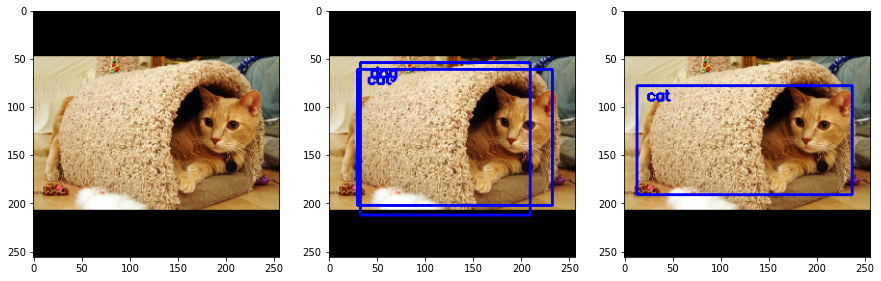

In [359]:
d = next(tsg)
fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(d[0][:,:,::-1])
plt.subplot(1, 3, 2)
plt.imshow(visualize(tf.expand_dims(d[0], 0), model(tf.expand_dims(d[0],0)), 0.3))
print("---")
plt.subplot(1, 3, 3)
plt.imshow(visualize(tf.expand_dims(d[0], 0), tf.expand_dims(d[1], 0), 1))
plt.show()

In [28]:
m = mAP()
print(d[0][idx:idx+1].shape)
print("mAP:", m(tf.Variable(d[1][idx:idx+1]), tf.Variable(model(d[0][idx:idx+1]))))

NameError: name 'idx' is not defined

# test

In [80]:
tf.reduce_sum(tf.cast(tf.math.is_nan(model(d[0])), tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [245]:
l = YOLOLoss()

l(tf.Variable(d[1]), model(d[0]))

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.76449980e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.59223902e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.89920019e-03 1.45877292e-02 0.00000000e+00
  0.00000000e+00 5.82491532e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.69128701e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0000000

<tf.Tensor: shape=(), dtype=float32, numpy=6.5295615>

In [ ]:
yt = [[1, 0], [0, 1]]
yp = [[0.99, 0.001], [0.001, 0.99]]

bce = tf.keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.NONE)

In [ ]:
bce(yt, yp, sample_weight=[2])

In [ ]:
tf.float32.max

In [ ]:
tf.math.exp(88.0)

In [ ]:
a = tf.cast(np.array(
    [[[[0], [3], [1], [2]], [[0], [0], [1], [2]], [[0], [1], [2], [9]]],
    [[[0], [3], [1], [2]], [[0], [0], [1], [2]], [[0], [1], [2], [9]]]]
), tf.float32)
a = tf.reshape(a, (2, 3, 4))

In [ ]:
print(a.shape)
print(a[...,1:].shape)
am = tf.argmax(a[...,1:], axis=-1)
print(am)

In [ ]:
tf.one_hot(am, 5)

In [ ]:
print(a)

In [ ]:
a_t = tf.zeros((4, 25))
a_p = tf.zeros((2, 25))

In [ ]:
aat = tf.expand_dims(a_t, 1)
aap = tf.expand_dims(a_p, 0)

print(aat.shape, aap.shape)

In [ ]:
aaps = tf.gather(aap, tf.argsort(aap[...,0], direction="DESCENDING")[0], axis=1)
print(aaps.shape)

In [ ]:
print(tf.maximum(aat[...,0], aap[...,1]).shape)
print((aat[...,0] - aap[...,1]).shape)

t = (aat[...,0] - aap[...,1])+1
tT = tf.transpose(t)
print(tf.reduce_max(tT, -1))
print(tT * tf.expand_dims(tf.reduce_max(tT, -1), -1))

In [ ]:
aT = tf.cast(np.array([[4, 5, 2, 3],[1, 6, 2, 9]]), tf.int32)
a = tf.transpose(aT)
print(aT)

In [ ]:
mx = tf.cast(tf.reduce_max(aT, -1) > 10, tf.int32)
print(mx)
print(aT * tf.expand_dims(mx, -1))

In [ ]:
m = tf.cast(np.array([[0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0]]), tf.int32)
print(m)

ask = tf.expand_dims(tf.reduce_sum(tf.transpose(m), -1), axis=-1)
ask = tf.where(ask>1, 1, ask)
print(ask)

In [ ]:
print(tf.one_hot(tf.argmax(m), 6, axis=1))
print(tf.one_hot(tf.argmax(m), 6, axis=1)*tf.cast(ask, tf.float32))
k = tf.cast(tf.transpose(tf.one_hot(tf.argmax(m), 6, axis=1)*tf.cast(ask, tf.float32)), tf.int32)
k

In [ ]:
print(tf.reduce_sum(k, -1))

In [ ]:
r = tf.cast(np.array([0.5, 0, 0.2, 0.3, 0.6, 0.9]), tf.float32)

In [ ]:
rr = tf.cast(tf.expand_dims(r, 0), tf.float32) >= tf.cast(tf.expand_dims(tf.range(0, 1.1, 0.1, dtype=tf.float64), -1), tf.float32)
rr

In [ ]:
r * tf.cast(rr, tf.float32)